<a href="https://colab.research.google.com/github/iam-pattan/Exploring-DL/blob/master/NASNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://ai.googleblog.com/2017/11/automl-for-large-scale-image.html

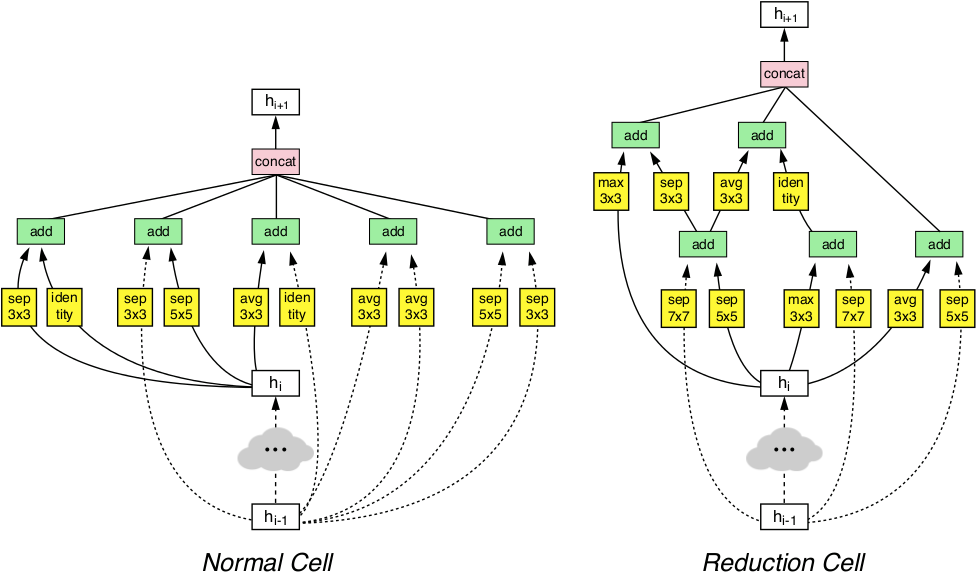

NASNet architecture is composed of two types of layers: Normal Layer (left), and Reduction Layer (right). These two layers are designed by AutoML

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt 

In [ ]:
data, meta = tfds.load('beans', 
                      as_supervised=True,
                      with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteT9JJ22/beans-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteT9JJ22/beans-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteT9JJ22/beans-test.tfrecord


Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [ ]:
raw_train = data['train']
raw_val = data['validation']
raw_test = data['test']

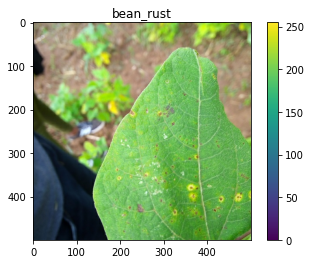

In [ ]:
label_extractor = meta.features['label'].int2str
for image,label in raw_train.take(1):
  plt.imshow(image)
  plt.title(label_extractor(label))
  plt.colorbar()
  plt.show()

In [ ]:
print(image.shape)
min(image.numpy().ravel()), max(image.numpy().ravel()) 

(500, 500, 3)


(0, 255)

In [ ]:
base = keras.applications.NASNetLarge(input_shape=(331,331,3),
                                      include_top=False,
                                      weights='imagenet') 

343613440/343610240 [==============================] - 2s 0us/step


In [ ]:
def scale_image(img, label):
  img = tf.cast(img,tf.float32)
  img = img/255.0
  img = tf.image.resize(img, (331,331))
  return img, label 

In [ ]:
train = raw_train.map(scale_image)
val = raw_val.map(scale_image)
test = raw_test.map(scale_image) 

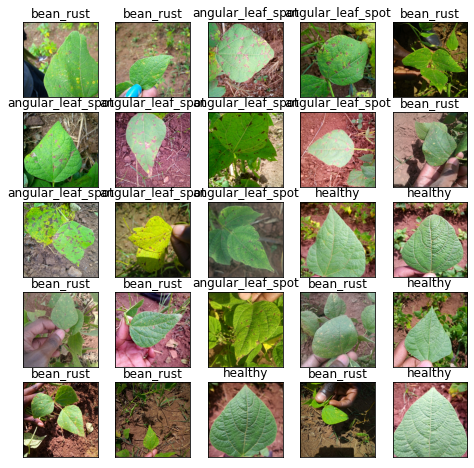

In [ ]:
plt.figure(figsize=(8,8))
i=1
for img, label in train.take(25):
  plt.subplot(5,5,i)
  plt.imshow(img)
  plt.title(label_extractor(label))
  plt.xticks([])
  plt.yticks([])
  i += 1
plt.show() 

In [ ]:
batch_size = 64
train_batches = train.batch(batch_size)
val_batches = val.batch(batch_size)

In [ ]:
base.trainable=False

In [ ]:
head = keras.models.Sequential([
                                keras.layers.GlobalAveragePooling2D(),
                                keras.layers.Dense(512, activation='relu'),
                                keras.layers.Dropout(0.5),
                                keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model = keras.models.Sequential([base, head])

In [ ]:
base.summary()

In [ ]:
head.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 4032)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2064896   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total params: 2,066,948
Trainable params: 2,066,948
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
sequential (Sequential)      (None, 3)                 2066435   
Total params: 86,983,253
Trainable params: 2,066,435
Non-trainable params: 84,916,818
_________________________________________________________________


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

In [ ]:
history = model.fit(train_batches, validation_data=val_batches, epochs=100, callbacks=callback)

Epoch 1/100
17/17 [==============================] - 87s 2s/step - loss: 0.9705 - accuracy: 0.5780 - val_loss: 0.4258 - val_accuracy: 0.8346
Epoch 2/100
17/17 [==============================] - 34s 2s/step - loss: 0.4941 - accuracy: 0.7735 - val_loss: 0.4598 - val_accuracy: 0.7895
Epoch 3/100
17/17 [==============================] - 36s 2s/step - loss: 0.3246 - accuracy: 0.8790 - val_loss: 0.4403 - val_accuracy: 0.8271
Epoch 4/100
17/17 [==============================] - 35s 2s/step - loss: 0.3173 - accuracy: 0.8799 - val_loss: 0.3442 - val_accuracy: 0.8571
Epoch 5/100
17/17 [==============================] - 35s 2s/step - loss: 0.2550 - accuracy: 0.9126 - val_loss: 0.2973 - val_accuracy: 0.8496
Epoch 6/100
17/17 [==============================] - 35s 2s/step - loss: 0.2218 - accuracy: 0.9274 - val_loss: 0.3388 - val_accuracy: 0.8722
Epoch 7/100
17/17 [==============================] - 35s 2s/step - loss: 0.1974 - accuracy: 0.9308 - val_loss: 0.3447 - val_accuracy: 0.8647
Epoch 8/100
1

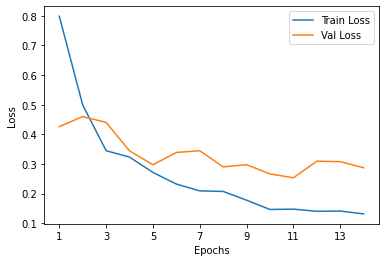

In [ ]:
hist = pd.DataFrame(history.history)
length = len(hist['loss'])
epochs = np.arange(1,length+1)

plt.plot(epochs,hist['loss'], label='Train Loss')
plt.plot(epochs,hist['val_loss'], label='Val Loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xticks(np.arange(1,length+1,2))
plt.show() 

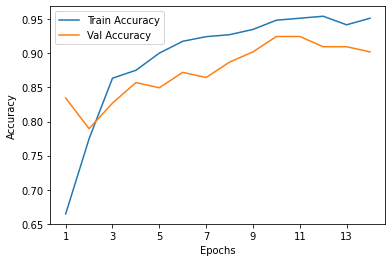

In [ ]:
plt.plot(epochs,hist['accuracy'], label='Train Accuracy')
plt.plot(epochs,hist['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(1,length+1,2))
plt.show() 

In [ ]:
len(base.layers)

1039

We can either use NASNetMobile instead of NASNetLarge or can train  300-350 layers in the base architecture and freeze the bottom 700 layers and fine-tune the top layers.

Ref: [Article](https://analyticsindiamag.com/transfer-learning-using-tensorflow-keras/)